In [48]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

In [35]:
class Discriminator(Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.dense_1 = Dense(64, activation='relu')
        self.dense_2 = Dense(32, activation='relu')
        self.dense_3 = Dense(32, activation='relu')
        self.flat_layer = Flatten()
        self.output_layer = Dense(10, activation='softmax')
        
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.flat_layer(x)
        output = self.output_layer(x)
        return output

In [36]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
model = Discriminator()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(x_train, y_train, epochs=10, batch_size=254, validation_data=(x_test, y_test))

Epoch 1/10
237/237 [==============================] - 2s 9ms/step - loss: 2.3155 - accuracy: 0.7229 - val_loss: 0.4445 - val_accuracy: 0.8743
Epoch 2/10
237/237 [==============================] - 2s 9ms/step - loss: 0.3557 - accuracy: 0.8969 - val_loss: 0.2720 - val_accuracy: 0.9177
Epoch 3/10
237/237 [==============================] - 2s 8ms/step - loss: 0.2444 - accuracy: 0.9274 - val_loss: 0.2167 - val_accuracy: 0.9352
Epoch 4/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1960 - accuracy: 0.9399 - val_loss: 0.1922 - val_accuracy: 0.9435
Epoch 5/10
237/237 [==============================] - 2s 9ms/step - loss: 0.1688 - accuracy: 0.9490 - val_loss: 0.1718 - val_accuracy: 0.9460
Epoch 6/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1502 - accuracy: 0.9538 - val_loss: 0.1688 - val_accuracy: 0.9471
Epoch 7/10
237/237 [==============================] - 2s 8ms/step - loss: 0.1390 - accuracy: 0.9577 - val_loss: 0.1570 - val_accuracy: 0.9511
Epoch 

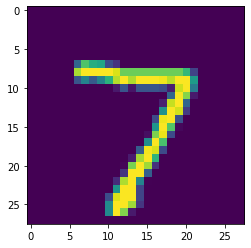

In [58]:
plt.imshow(x_test[0])

In [56]:
res = model.predict(x_test[1:2])